In [3]:
!nvidia-smi

Sun Aug  9 02:16:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   35C    P8     7W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import os
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

import utils

In [6]:
seed = 781
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [12]:
%%time
pairs = [*zip(
    utils.read_file('./data/europarl-v7.fr-en.fr'),
    utils.read_file('./data/europarl-v7.fr-en.en')
)]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs):,}')

Number of examples: 2,007,723
CPU times: user 3.55 s, sys: 885 ms, total: 4.44 s
Wall time: 4.43 s


In [13]:
%%time
pairs = np.random.choice(pairs, size=200_000, replace=False)
pairs = [*map(
    lambda pair: {k: v for k, v in pair.items()}, # utils.normalize_string(v)
    pairs
)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples after sampling: 200,000
Example:
	FR => C'est pourquoi j'ai quelque appréhension, si nous accordons à certains pays une flexibilité spéciale, car alors dans le pire des cas ils seront perdants, en d'autres termes ils ne bénéficieront pas des avantages technologiques que les autres pays de l'UE recevront.

	EN => For this reason, I am slightly concerned if we are going to allow some countries special flexibility, as then in the worst-case scenario they will be losing out, which is to say they will not receive the technological benefits that the other EU countries will.

CPU times: user 1.31 s, sys: 43.9 ms, total: 1.36 s
Wall time: 1.35 s


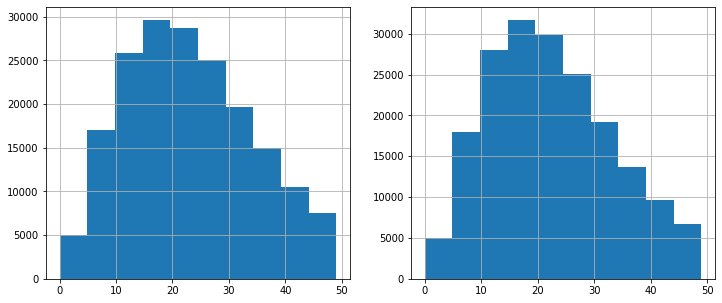

In [18]:
len_fr = [*map(lambda pair: len(pair['fr'].split()), pairs)]
len_en = [*map(lambda pair: len(pair['en'].split()), pairs)]

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist([*filter(lambda x: x < 50, len_fr)])
axes[0].grid(True)
axes[1].hist([*filter(lambda x: x < 50, len_en)])
axes[1].grid(True)
plt.show()

In [47]:
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True) # For pack_padded_sequence
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en')

MIN_LENGTH, MAX_LENGTH = 20, 30

examples = [Example.fromdict(
    data=pair,
    fields={
        'fr': ('src', FR),
        'en': ('dest', EN)
    }
) for pair in tqdm.tqdm(pairs)]
examples = [*filter(
    lambda example: MIN_LENGTH <= len(example.src) and len(example.src) <= MAX_LENGTH \
        and MIN_LENGTH <= len(example.dest) and len(example.dest) <= MAX_LENGTH,
    examples
)]
print(f'Number of examples after filtering: {len(examples):,}')

100%|██████████| 200000/200000 [01:20<00:00, 2485.55it/s]


Number of examples after filtering: 39,016


In [48]:
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.8, 0.1, 0.1])
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

train set size: 31,213
valid set size: 3,901
test set size: 3,902
{'src': ["c'", 'est', 'pour', 'cette', 'raison', 'que', 'nous', 'assistons', 'à', 'épuisement', 'majeur', 'des', 'stocks', 'de', 'poissons', 'et', 'nous', 'en', 'serons', 'tous', 'affectés', '.'], 'dest': ['that', 'is', 'why', 'we', 'are', 'seeing', 'great', 'depletion', 'of', 'fish', 'stocks', ',', 'and', 'we', 'will', 'all', 'suffer', 'in', 'the', 'end', '.']}


In [49]:
MIN_COUNT = 5
FR.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
print(f'Length of FR vocabulary: {len(FR.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 7,955
Length of EN vocabulary: 6,512


In [59]:
class EncoderLSTM(nn.Module):
    
    def __init__(
        self,
        embedding_size,
        vocab_size,
        hidden_size,
        n_layers,
        dropout,
        recurrent_dropout
    ):
        super(EncoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            bidirectional=True,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
    
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            outputs: Tensor[seq_len, batch_size, 2 * hidden_size]
            hn: Tensor[n_layers * 2, batch_size, hidden_size]
            cn: Tensor[n_layers * 2, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = self.dropout(embedded)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, (hn, cn) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return outputs, hn, cn

In [78]:
def test_encoder():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    encoder = EncoderLSTM(
        embedding_size=300,
        vocab_size=len(FR.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    for data in train_iterator:
        outputs, hn, cn = encoder(
            input_sequences=data.src[0],
            sequence_lengths=data.src[1]
        )
        seq_len = data.src[0].size(0)
        assert outputs.size() == torch.Size([seq_len, batch_size, 2 * 256]), outputs.size()
        assert hn.size() == torch.Size([4 * 2, batch_size, 256]), hn.size()
        assert cn.size() == torch.Size([4 * 2, batch_size, 256]), cn.size()
        break
    
test_encoder()